In [1]:
import cv2
import numpy as np
from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
import imutils
import argparse
import os
import math
from time import  time
import matplotlib.pyplot as plt
from classification import training, getLabel

SIGNS = ["ERROR",
        "STOP",
        "TURN LEFT",
        "TURN RIGHT",
        "DO NOT TURN LEFT",
        "DO NOT TURN RIGHT",
        "ONE WAY",
        "SPEED LIMIT",
        "OTHER"]
image = cv2.imread('../images/right2.png')
image = cv2.cvtColor( image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

# Clean all previous file
def clean_images():
	file_list = os.listdir('./')
	for file_name in file_list:
		if '.png' in file_name:
			os.remove(file_name)
### Preprocess image


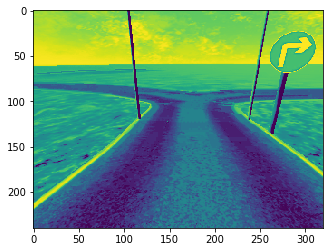

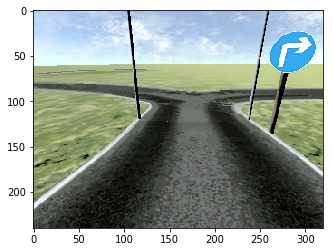

In [2]:
def constrastLimit(image):
    img_hist_equalized = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    channels = cv2.split(img_hist_equalized)
#     cv2.imshow("12",channels[1])
    channels[0] = cv2.equalizeHist(channels[0])
    plt.figure()
    plt.imshow(channels[0])
    
    cv2.waitKey(0)
    img_hist_equalized = cv2.merge(channels)
    img_hist_equalized = cv2.cvtColor(img_hist_equalized, cv2.COLOR_YCrCb2BGR)
    return img_hist_equalized
img_hist_equalized = constrastLimit(image)
plt.figure()
plt.imshow(img_hist_equalized)

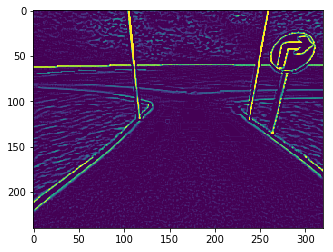

In [3]:
def LaplacianOfGaussian(image):
    LoG_image = cv2.GaussianBlur(image, (3,3), 0)           # paramter 
    gray = cv2.cvtColor( LoG_image, cv2.COLOR_BGR2GRAY)
    LoG_image = cv2.Laplacian( gray, cv2.CV_8U,3,3,2)       # parameter
    LoG_image = cv2.convertScaleAbs(LoG_image)
    return LoG_image
LoG_image = LaplacianOfGaussian(image)
plt.imshow(LoG_image)

In [4]:
def binarization(image):
#     image= cv2.cvtColor( image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(image,40,255,cv2.THRESH_BINARY)[1]
#     thresh = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    return thresh
# thresh = binarization(image)
# plt.imshow(thresh)

In [ ]:
def preprocess_image(image):
    image = constrastLimit(image)
    plt.figure()
    plt.imshow(image)
    image = LaplacianOfGaussian(image)
    plt.figure()
    plt.imshow(image,cmap = 'gray')
    image = binarization(image)
    plt.figure()
    plt.imshow(image, cmap = 'gray')
    return image
preprocess_image1 = preprocess_image(image)
# plt.imshow(preprocess_image1)

In [ ]:
# Find Signs
def removeSmallComponents(image, threshold):
    #find all your connected components (white blobs in your image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[1:, -1]; nb_components = nb_components - 1

    img2 = np.zeros((output.shape),dtype = np.uint8)
    #for every component in the image, you keep it only if it's above threshold
    for i in range(0, nb_components):
        if sizes[i] >= threshold:
            img2[output == i + 1] = 255
    return img2
# img2 = removeSmallComponents(image, 10)
# plt.imshow(img2)

In [ ]:
def findContour(image):
    #find contours in the thresholded image
    cnts = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE    )
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    return cnts
cnts1 = (findContour(preprocess_image1))
# print(cnts1)
cv2.drawContours(image,cnts1,10,(0,255,0),3)

plt.imshow(image)

In [ ]:








    







def contourIsSign(perimeter, centroid, threshold):
    #  perimeter, centroid, threshold
    # # Compute signature of contour
    result=[]
    for p in perimeter:
        p = p[0]
        distance = sqrt((p[0] - centroid[0])**2 + (p[1] - centroid[1])**2)
        result.append(distance)
    max_value = max(result)
    signature = [float(dist) / max_value for dist in result ]
    # Check signature of contour.
    temp = sum((1 - s) for s in signature)
    temp = temp / len(signature)
    if temp < threshold: # is  the sign
        return True, max_value + 2
    else:                 # is not the sign
        return False, max_value + 2

#crop sign 
def cropContour(image, center, max_distance):
    width = image.shape[1]
    height = image.shape[0]
    top = max([int(center[0] - max_distance), 0])
    bottom = min([int(center[0] + max_distance + 1), height-1])
    left = max([int(center[1] - max_distance), 0])
    right = min([int(center[1] + max_distance+1), width-1])
    # print(left, right, top, bottom)
    return image[left:right, top:bottom]

def cropSign(image, coordinate):
    width = image.shape[1]
    height = image.shape[0]
    top = max([int(coordinate[0][1]), 0])
    bottom = min([int(coordinate[1][1]), height-1])
    left = max([int(coordinate[0][0]), 0])
    right = min([int(coordinate[1][0]), width-1])
    #print(top,left,bottom,right)
    return image[top:bottom,left:right]


def findLargestSign(image, contours, threshold, distance_theshold):
    max_distance = 0
    coordinate = None
    sign = None
    for c in contours:
        M = cv2.moments(c)
        if M["m00"] == 0:
            continue
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        is_sign, distance = contourIsSign(c, [cX, cY], 1-threshold)
        if is_sign and distance > max_distance and distance > distance_theshold:
            max_distance = distance
            coordinate = np.reshape(c, [-1,2])
            left, top = np.amin(coordinate, axis=0)
            right, bottom = np.amax(coordinate, axis = 0)
            coordinate = [(left-2,top-2),(right+3,bottom+1)]
            sign = cropSign(image,coordinate)
    return sign, coordinate


def findSigns(image, contours, threshold, distance_theshold):
    signs = []
    coordinates = []
    for c in contours:
        # compute the center of the contour
        M = cv2.moments(c)
        if M["m00"] == 0:
            continue
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        is_sign, max_distance = contourIsSign(c, [cX, cY], 1-threshold)
        if is_sign and max_distance > distance_theshold:
            sign = cropContour(image, [cX, cY], max_distance)
            signs.append(sign)
            coordinate = np.reshape(c, [-1,2])
            top, left = np.amin(coordinate, axis=0)
            right, bottom = np.amax(coordinate, axis = 0)
            coordinates.append([(top-2,left-2),(right+1,bottom+1)])
    return signs, coordinates

def localization(image, min_size_components, similitary_contour_with_circle):
    original_image = image.copy()
    binary_image = preprocess_image(image)

    binary_image = removeSmallComponents(binary_image, min_size_components)

    binary_image = cv2.bitwise_and(binary_image,binary_image, mask=remove_other_color(image))

    #binary_image = remove_line(binary_image)

    #cv2.imshow('BINARY IMAGE', binary_image)
    plt.imshow(binary_image, cmap = 'gray')
    plt.show()
    contours = findContour(binary_image)
    #signs, coordinates = findSigns(image, contours, similitary_contour_with_circle, 15)
    sign, coordinate = findLargestSign(original_image, contours, similitary_contour_with_circle, 15) #50m
    plt.figure()
    plt.imshow(sign)
    text = ""
#     sign_type = -1
#     i = 0

#     if sign is not None:
#         sign_type = getLabel(model, sign)
#         sign_type = sign_type if sign_type <= 8 else 8
#         text = SIGNS[sign_type]
#         cv2.imwrite(str(count)+'_'+text+'.png', sign)

#     if sign_type > 0 and sign_type != current_sign_type:        
#         cv2.rectangle(original_image, coordinate[0],coordinate[1], (0, 255, 0), 1)
#         font = cv2.FONT_HERSHEY_PLAIN
#         cv2.putText(original_image,text,(coordinate[0][0], coordinate[0][1] -15), font, 1,(0,0,255),2,cv2.LINE_4)
#     return coordinate, original_image, sign_type, text



In [ ]:
def remove_line(img):
    gray = img.copy()
    edges = cv2.Canny(gray,50,150,apertureSize = 3)
    minLineLength = 5
    maxLineGap = 3
    lines = cv2.HoughLinesP(edges,1,np.pi/180,15,minLineLength,maxLineGap)
    mask = np.ones(img.shape[:2], dtype="uint8") * 255
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(mask,(x1,y1),(x2,y2),(0,0,0),2)
    return cv2.bitwise_and(img, img, mask=mask)

def remove_other_color(img):
    frame = cv2.GaussianBlur(img, (3,3), 0) 
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_blue = np.array([100,128,0])
    upper_blue = np.array([215,255,255])
    # Threshold the HSV image to get only blue colors
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    lower_white = np.array([0,0,128], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    # Threshold the HSV image to get only blue colors
    mask_white = cv2.inRange(hsv, lower_white, upper_white)

    lower_black = np.array([0,0,0], dtype=np.uint8)
    upper_black = np.array([170,150,50], dtype=np.uint8)

    mask_black = cv2.inRange(hsv, lower_black, upper_black)

    mask_1 = cv2.bitwise_or(mask_blue, mask_white)
    mask = cv2.bitwise_or(mask_1, mask_black)
    # Bitwise-AND mask and original image
    #res = cv2.bitwise_and(frame,frame, mask= mask)
    return mask
SIGNS_LOOKUP = {
(1,0): "Turn Left",
(0,1): "Turn Right"
}
SIGNS_LOOKUP = {
(1,0): "Turn Left",
(0,1): "Turn Right"
}


count_sign = 1
def detect_traffic_sign(image, mask, THRESHOLD = 100):
    """ Image is from camera """
    

    contours = findContour(mask)
    sign, coordinate = findLargestSign(image, contours, 0.55, 10)
    k = cv2.waitKey(1)
    if k == ord('s'):         # wait for ESC key to exit
        cv2.imwrite('sign/sign_{}.png'.format(np.random.randint(1,10000)),sign)
        cv2.imwrite('Image/image_{}.png'.format(np.random.randint(1,10000)),image)
    
    cv2.imshow('sign',sign)
    cv2.waitKey(1)
    cv2.rectangle(image, coordinate[0],coordinate[1],(0,255,0))
#     plt.figure()
#     plt.imshow(sign)
#     plt.title('detect sign')
    sign_gray_image = cv2.cvtColor(sign,cv2.COLOR_BGR2GRAY)
    _,sign_gray_image = cv2.threshold(sign_gray_image,127,255,cv2.THRESH_BINARY_INV)
    sign_gray_image = cv2.bitwise_not(sign_gray_image)
    
    (subHeight, subWidth) = sign_gray_image.shape[0]/5,sign_gray_image.shape[1]/5
    subHeight = int(subHeight)
    subWidth = int(subWidth)

    # cv2.rectangle(sign, (int(0.5*subWidth), 1*subHeight), (int(1.5*subWidth), 2*subHeight), (0,255,0),2) # left block
    # cv2.rectangle(sign, (int(3.5*subWidth), 1*subHeight), (int(4.5*subWidth), 2*subHeight), (255,0,0),2) # right block
    # plt.figure()
    # plt.imshow(sign_gray_image,cmap='gray')
    # plt.title('sign')
    leftBlock = sign_gray_image[int(1.5*subHeight):int(2.5*subHeight), int(0.5*subWidth):int(1.5*subWidth)]
    rightBlock = sign_gray_image[int(1.5*subHeight):int(2.5*subHeight), int(3.5*subWidth):int(4.5*subWidth)]
    
    print(np.sum(leftBlock),np.sum(rightBlock),'left-----right')
    leftFraction = np.sum(leftBlock)/(leftBlock.shape[0]*leftBlock.shape[1])
    rightFraction = np.sum(rightBlock)/(rightBlock.shape[0]*rightBlock.shape[1])
    segments = (leftFraction, rightFraction)
    print(coordinate[1],'coordinate')
    if (leftFraction > rightFraction and leftFraction > 100):
        return 'Left',coordinate[1][0],coordinate[1][1]
    elif (leftFraction < rightFraction and rightFraction > 100):
        return 'Right',coordinate[1][0],coordinate[1][1]


In [ ]:
def main():
    start = time()
    img = cv2.imread('../images/right3.png') 
    gray_img = cv2.imread('../images/right3.png',0)
#     lower_blue = np.array([90,110,50])
#     upper_blue = np.array([110,255,255])
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#     kernel = np.ones((3,3),np.uint8)
#     mask = cv2.inRange(hsv, lower_blue, upper_blue)
#     mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
#     mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
#     # detect_sign(img)
#     direction = detect_traffic_sign(img,mask)
#     print(direction)
#     end = time(); print(end-start,'duration')
    # cap = cv2.VideoCapture('video/detect_lane.mp4')
    # while (cap.isOpened()):
    #     ret, frame = cap.read()
    #     detect_sign(frame)
        
    #     cv2.imshow('View',frame)
    #     k = cv2.waitKey(1)
    #     if k == ord('q'): # wait for 's' key to save and exit
    #         cv2.destroyAllWindows()
    #         rospy.signal_shutdown('Exit')    
        
    # cap.release()
    # cv2.destroyAllWindows()
    

    current_sign = None
    localization(img, 300, 0.65)
if __name__ == '__main__':
    main()